In [11]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import os

foldername = "trained-one-inner-l2"

dirs = Path.cwd() / foldername
rolling_window = 50
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams["figure.autolayout"] = True

# If this variable is set to True, the data plotted will be the last `rolling_window`
# many losses / accuracies averaged together.
# When this is set to 
endofepoch = False

In [12]:
epochs = list(dirs.glob("Epoch */*.csv"))
stats = {
    "train-acc.csv": [],
    "train-loss.csv": [],
    "test-acc.csv": [],
    "test-loss.csv": [],
}
epochwisestats = {
    "train-acc.csv": [],
    "train-loss.csv": [],
    "test-acc.csv": [],
    "test-loss.csv": [],
}
aucstats = {
    "train-preds.csv": [],
    "test-preds.csv": [],
}
epochwiseauc = {
    "train-preds.csv": {},
    "test-preds.csv": {},
}

maxepochs = -1
for i in epochs:
    info = str(i).replace(str(dirs) + "\\", "").split("\\")
    info = [int(info[0].replace("Epoch ", "")), info[1]]
    df = pd.read_csv(i, header = None if "pred" not in info[1] else 0) 
    if "loss" in info[1]:
        epochwisestats[info[1]].append(
            (info[0], df.mean().values.tolist()[0]) if not endofepoch else
              (info[0], df.values[-rolling_window:].mean().tolist())
        )
        df = df.rolling(window = rolling_window).mean().dropna()
        stats[info[1]].append((info[0], df.T.values[0].tolist()))
        
    elif "acc" in info[1]:
        epochwisestats[info[1]].append((info[0], df.mean().values.tolist()[0]))
        df = df.rolling(window = rolling_window).mean().dropna()
        stats[info[1]].append((info[0], df.T.values[0].tolist()))

    elif "pred" in info[1]:
        epochwiseauc[info[1]][info[0]] = roc_curve(df["actual"], df["preds"])
        aucstats[info[1]].append((info[0], roc_auc_score(df["actual"], df["preds"])))

    maxepochs = max(maxepochs, info[0])

for key in stats.keys():
    stats[key].sort(key = lambda x: x[0])
    stats[key] = sum([i[1] for i in stats[key]], [])

for key in aucstats.keys():
    aucstats[key].sort(key = lambda x: x[0])
    aucstats[key] = [i[1] for i in aucstats[key]]

for key in epochwisestats.keys():
    epochwisestats[key].sort(key = lambda x: x[0])
    epochwisestats[key] = [i[1] for i in epochwisestats[key]]

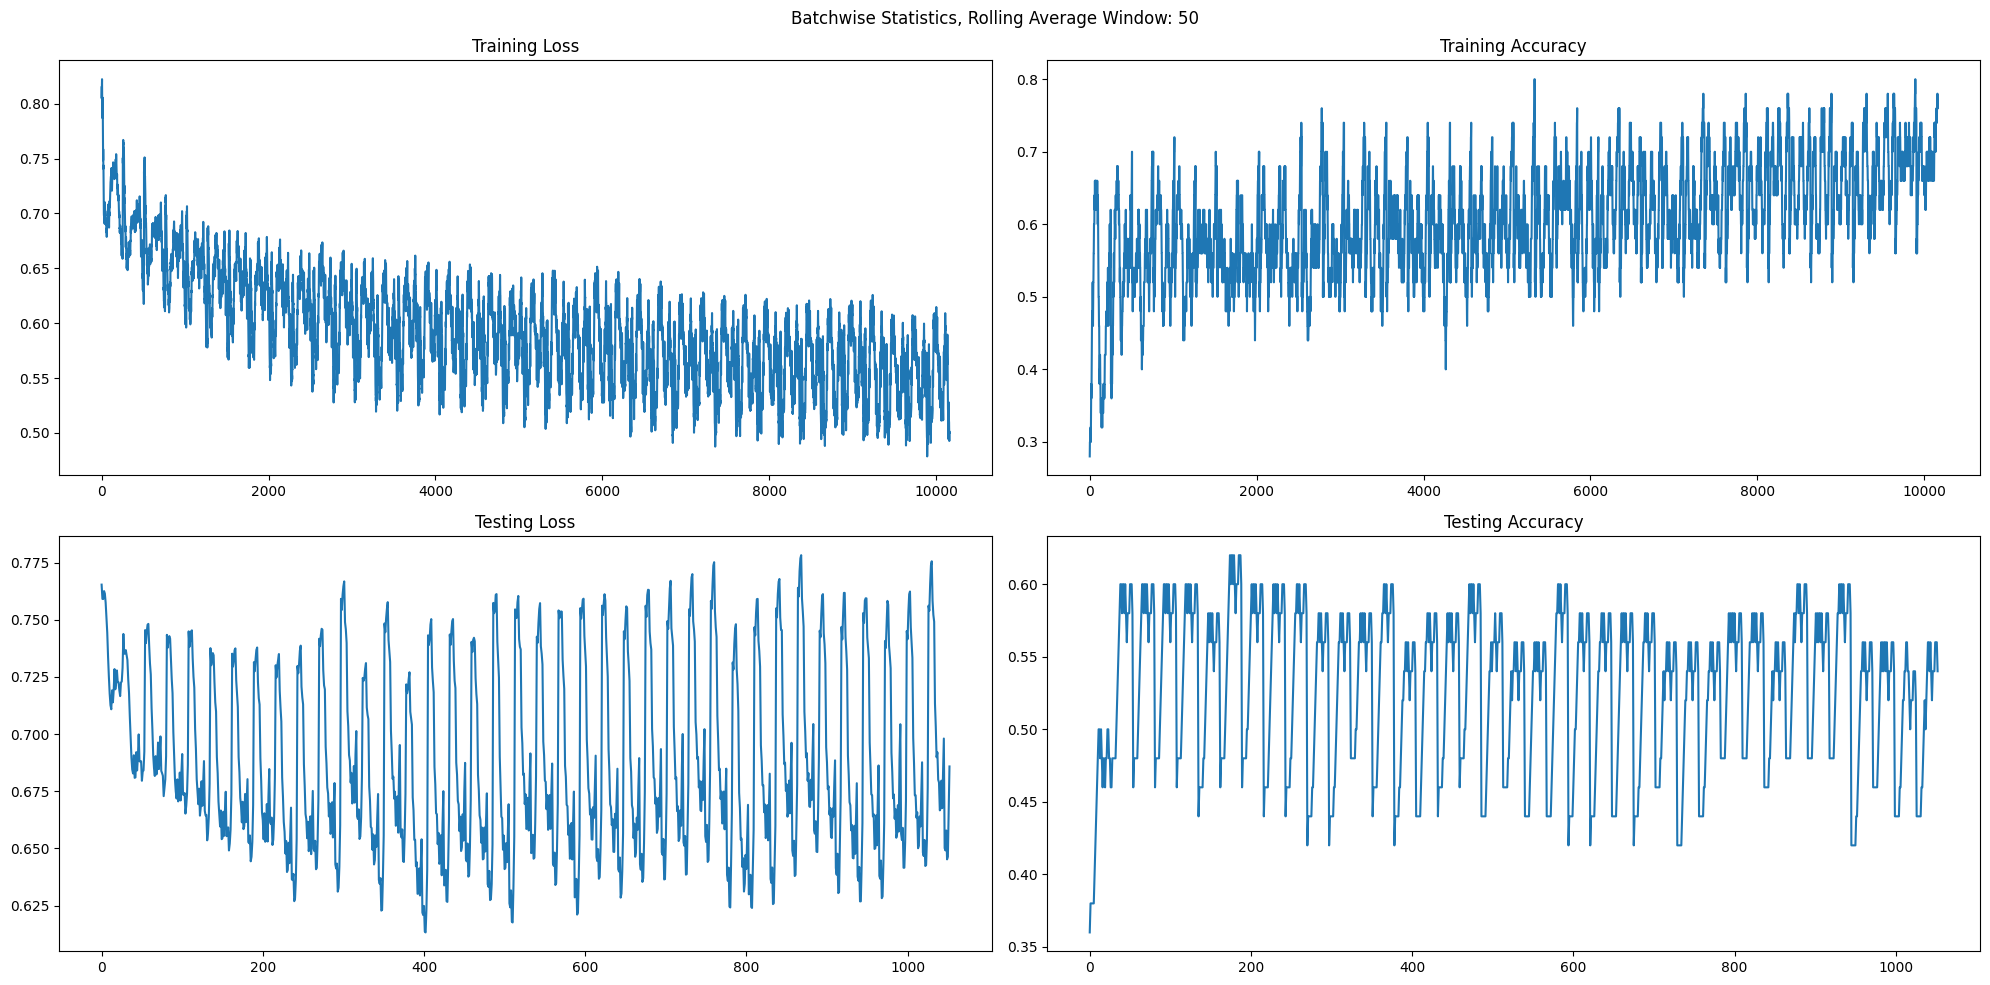

In [13]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(stats["train-loss.csv"])
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(stats["test-loss.csv"])
axs[1, 0].set_title("Testing Loss")

axs[0, 1].plot(stats["train-acc.csv"])
axs[0, 1].set_title("Training Accuracy")

axs[1, 1].plot(stats["test-acc.csv"])
axs[1, 1].set_title("Testing Accuracy")

fig.suptitle(f"Batchwise Statistics, Rolling Average Window: {rolling_window}")
plt.show()

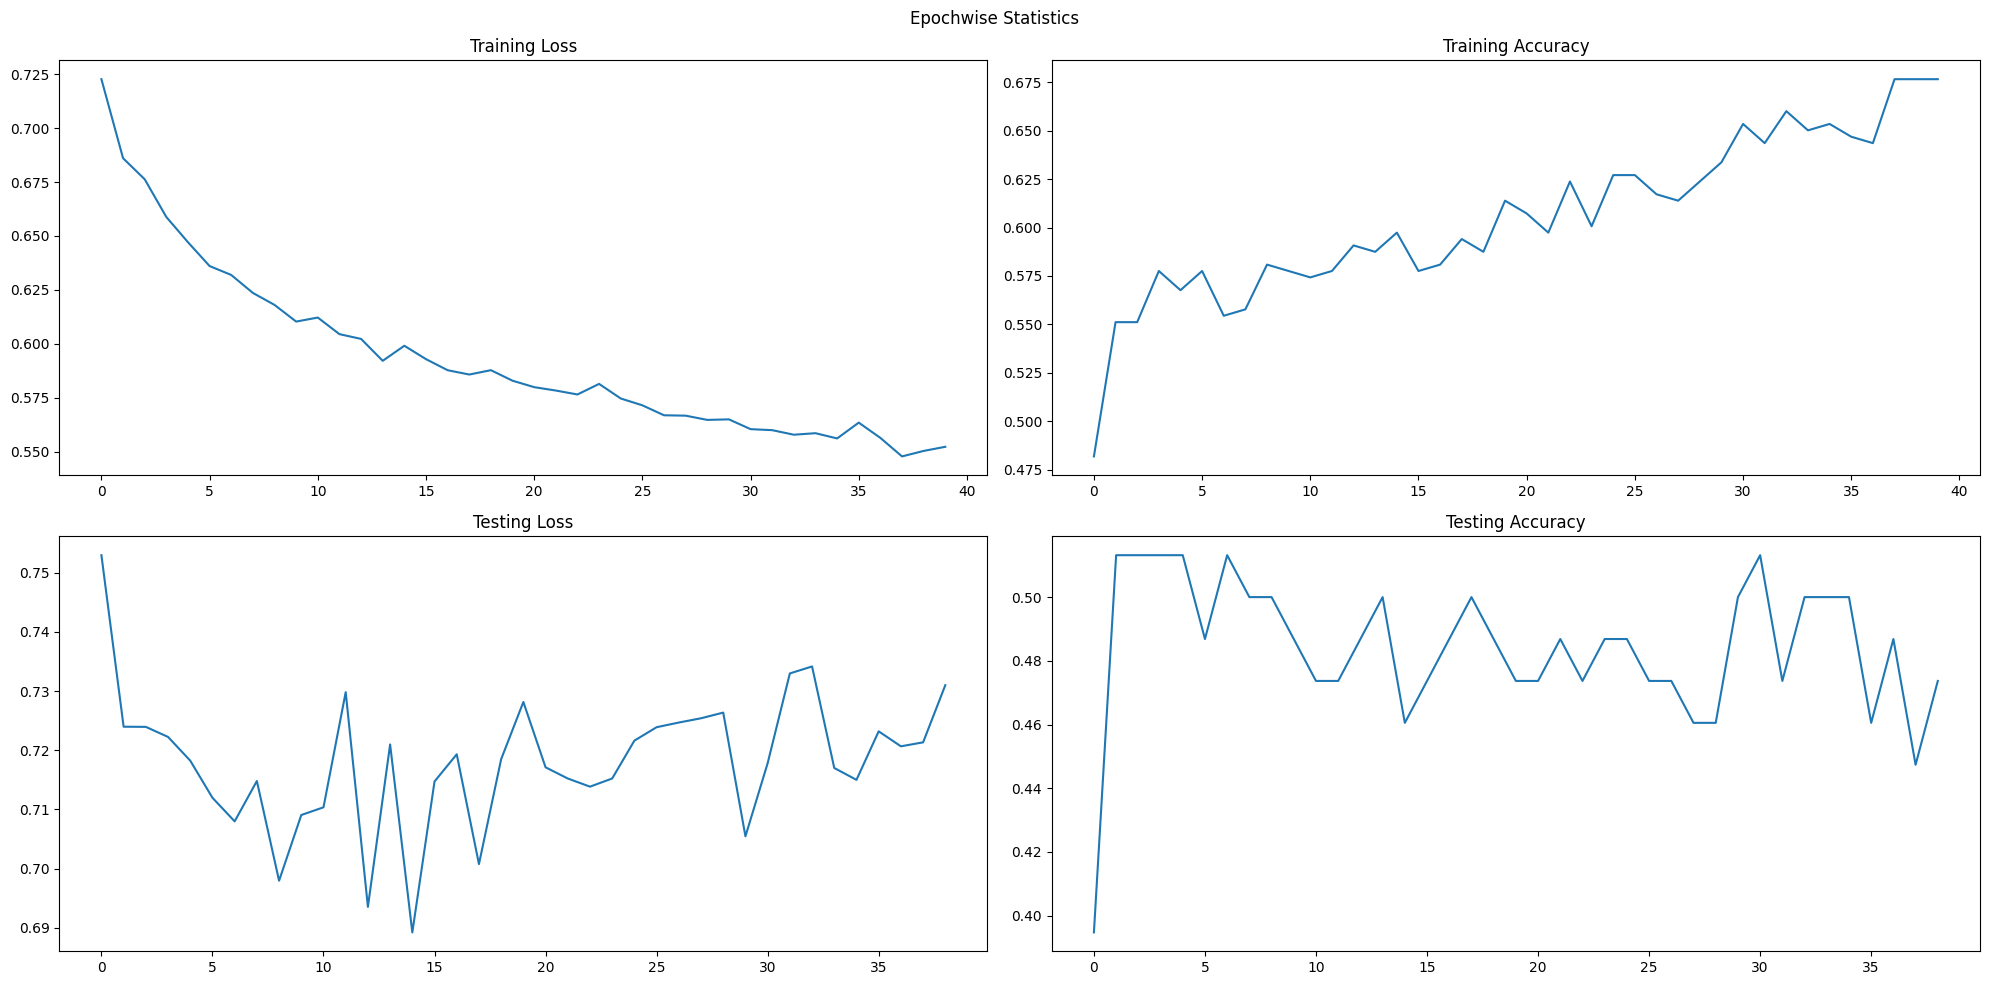

In [14]:
fig, axs = plt.subplots(ncols = 2, nrows = 2)
axs[0, 0].plot(epochwisestats["train-loss.csv"])
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(epochwisestats["test-loss.csv"])
axs[1, 0].set_title("Testing Loss")

axs[0, 1].plot(epochwisestats["train-acc.csv"])
axs[0, 1].set_title("Training Accuracy")

axs[1, 1].plot(epochwisestats["test-acc.csv"])
axs[1, 1].set_title("Testing Accuracy")

fig.suptitle(f"Epochwise Statistics")
plt.show()

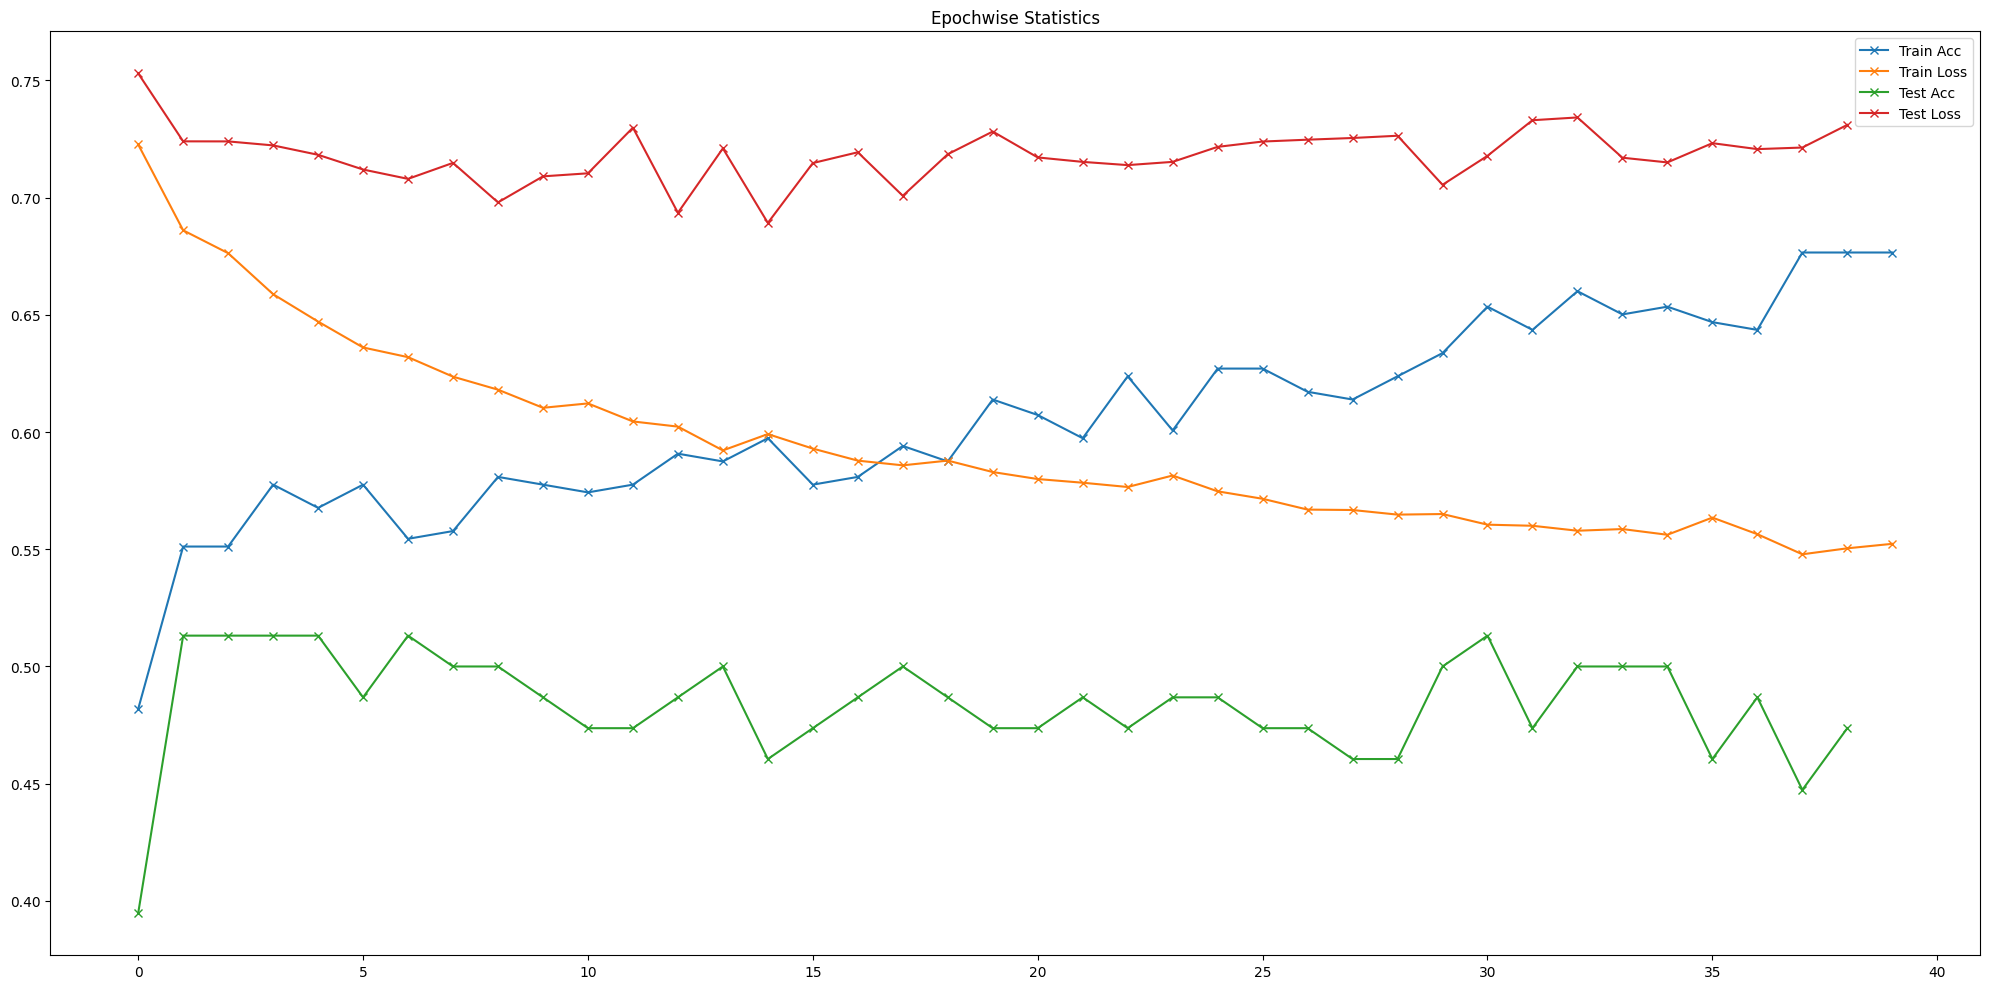

In [15]:
for key, val in epochwisestats.items():
    plt.plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
plt.title("Epochwise Statistics")
plt.legend()
plt.show()

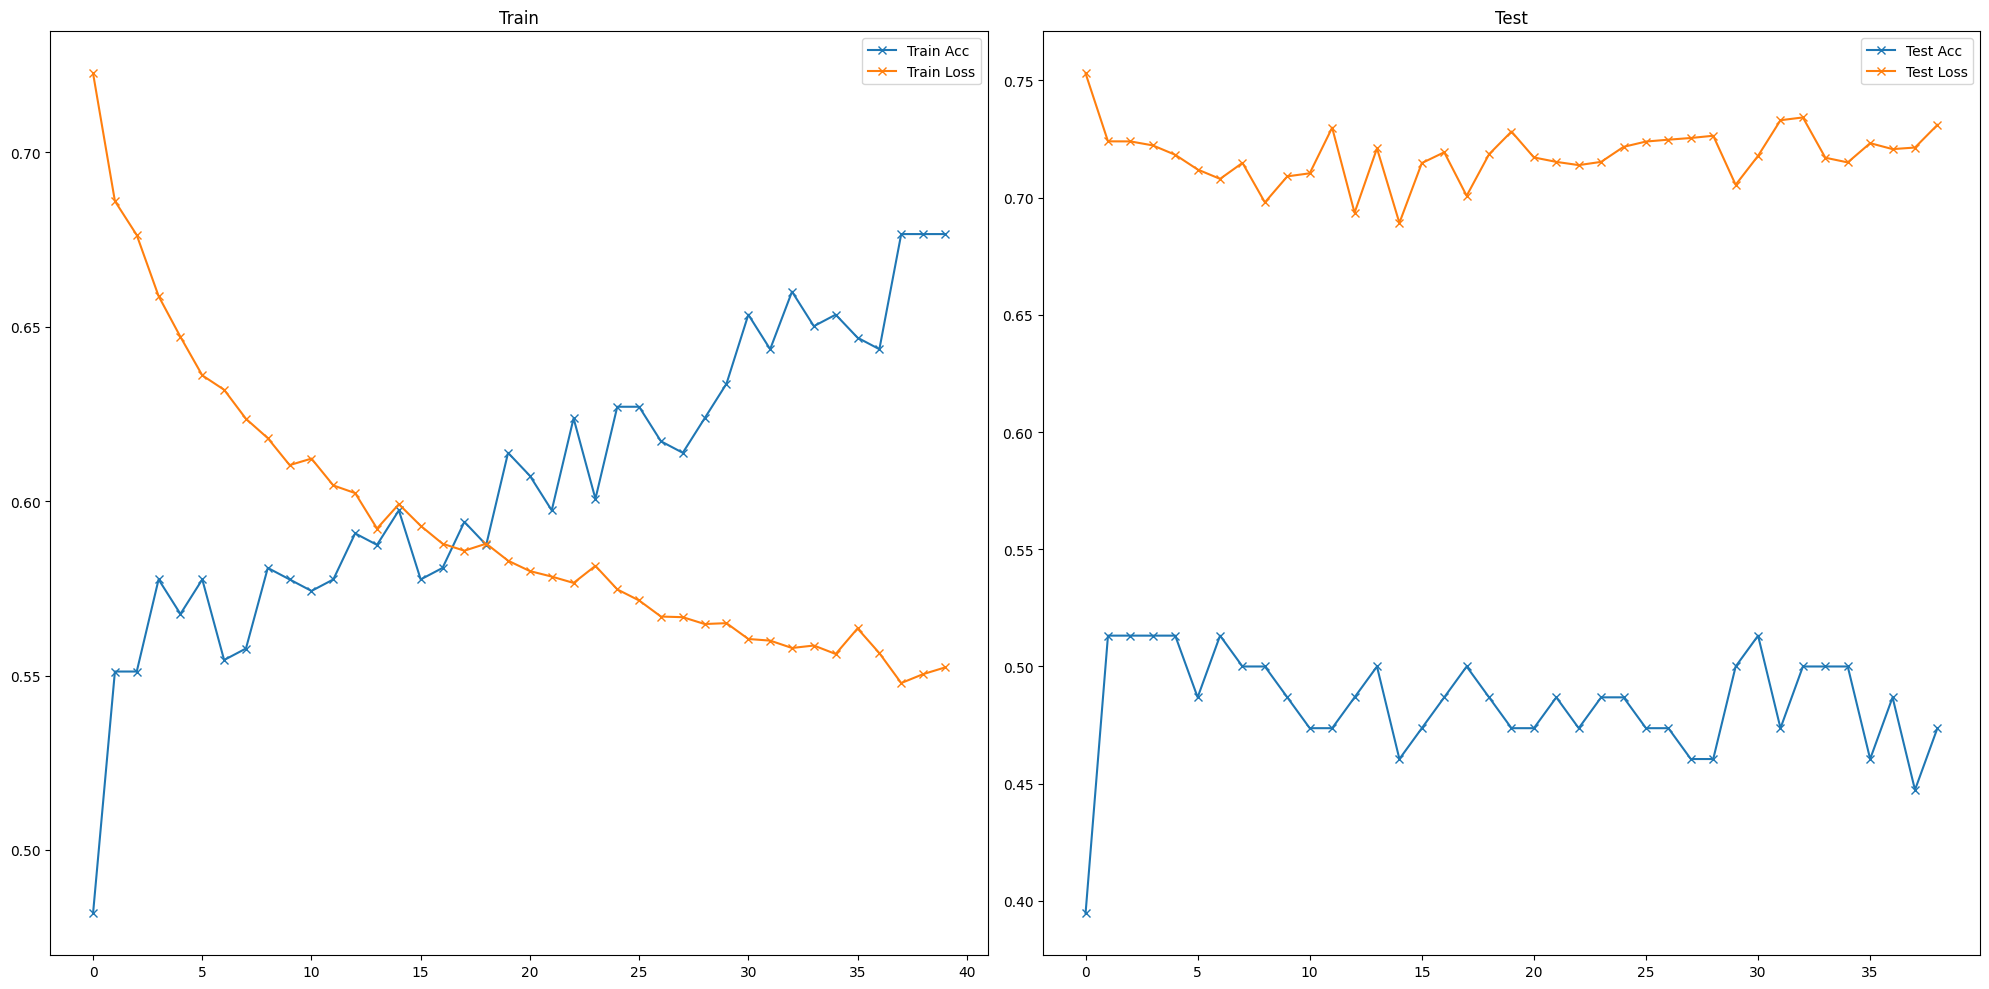

In [16]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "train" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
axs[0].legend()
axs[0].set_title("Train")
axs[1].legend()
axs[1].set_title("Test")
plt.show()

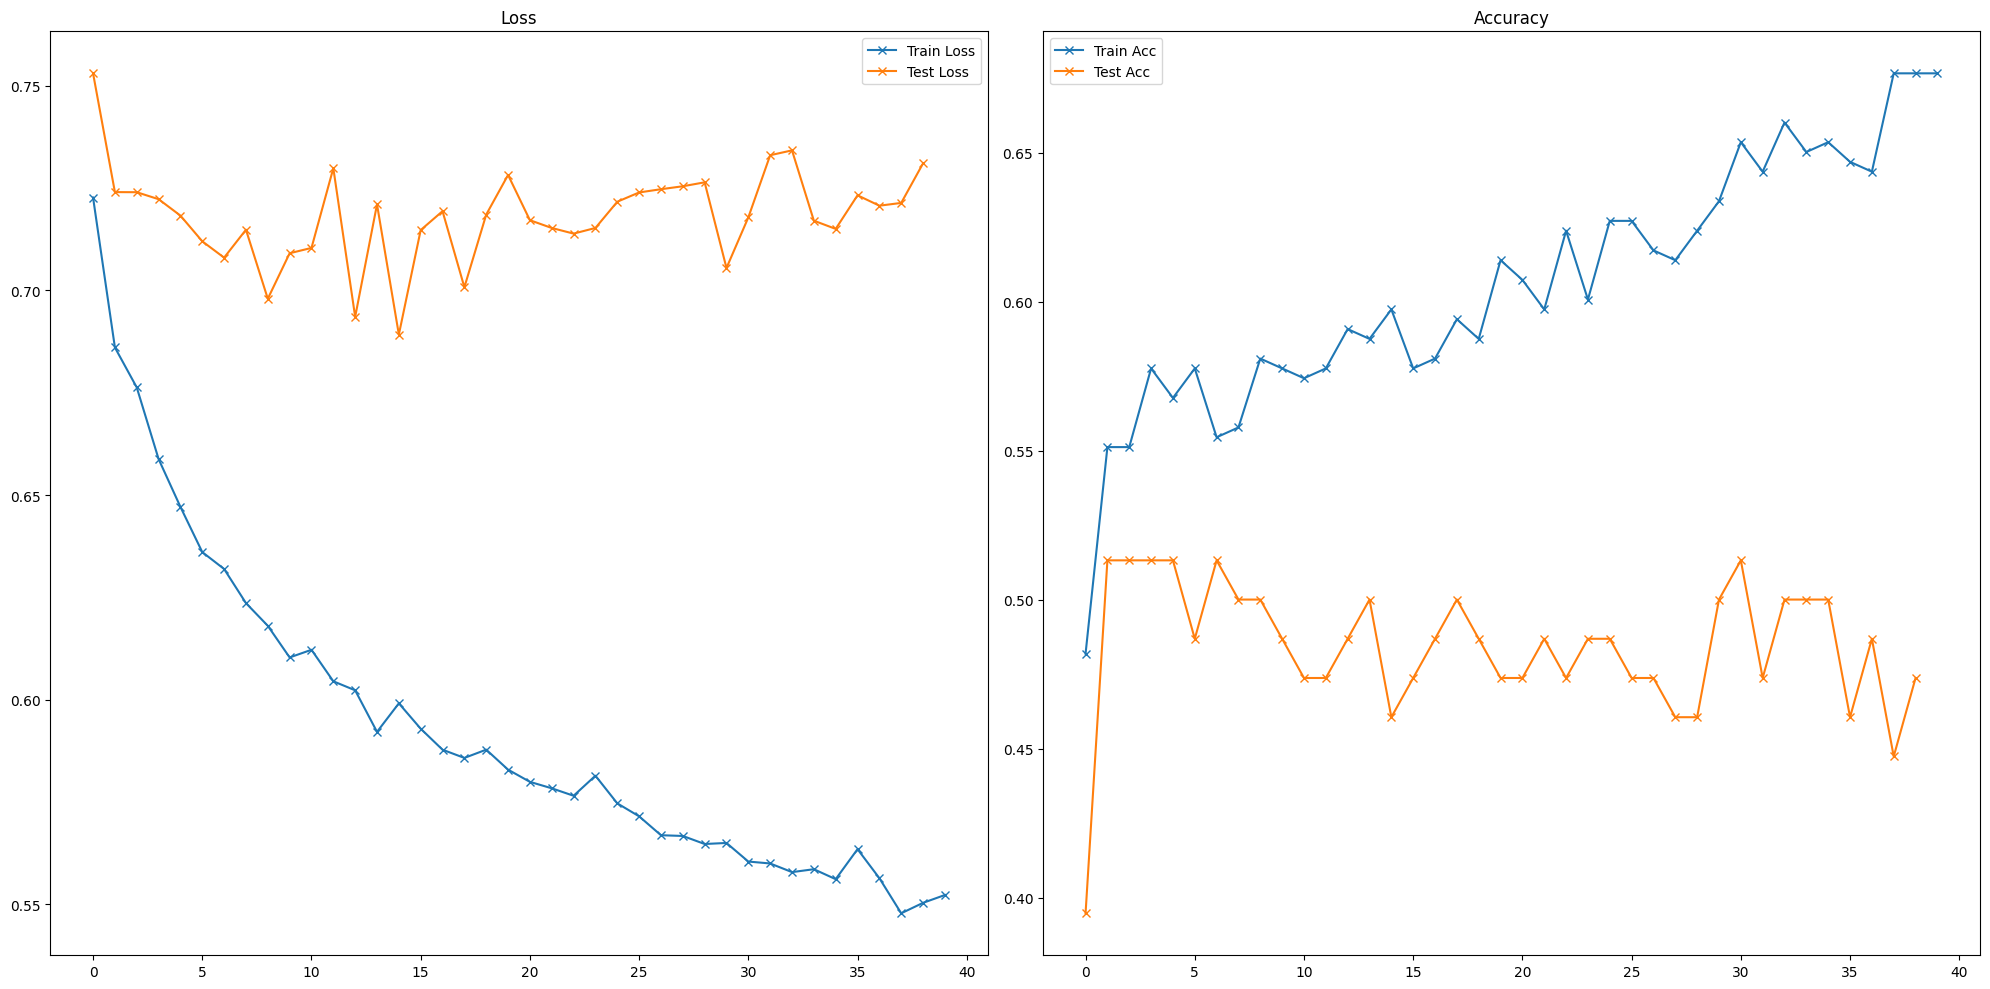

In [17]:
fig, axs = plt.subplots(ncols = 2)

for key, val in epochwisestats.items():
    axs[0 if "loss" in key else 1].plot(val, label = " ".join(key.replace(".csv", "").split("-")).title(), marker = "x")
axs[0].legend()
axs[1].legend()
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
plt.show()

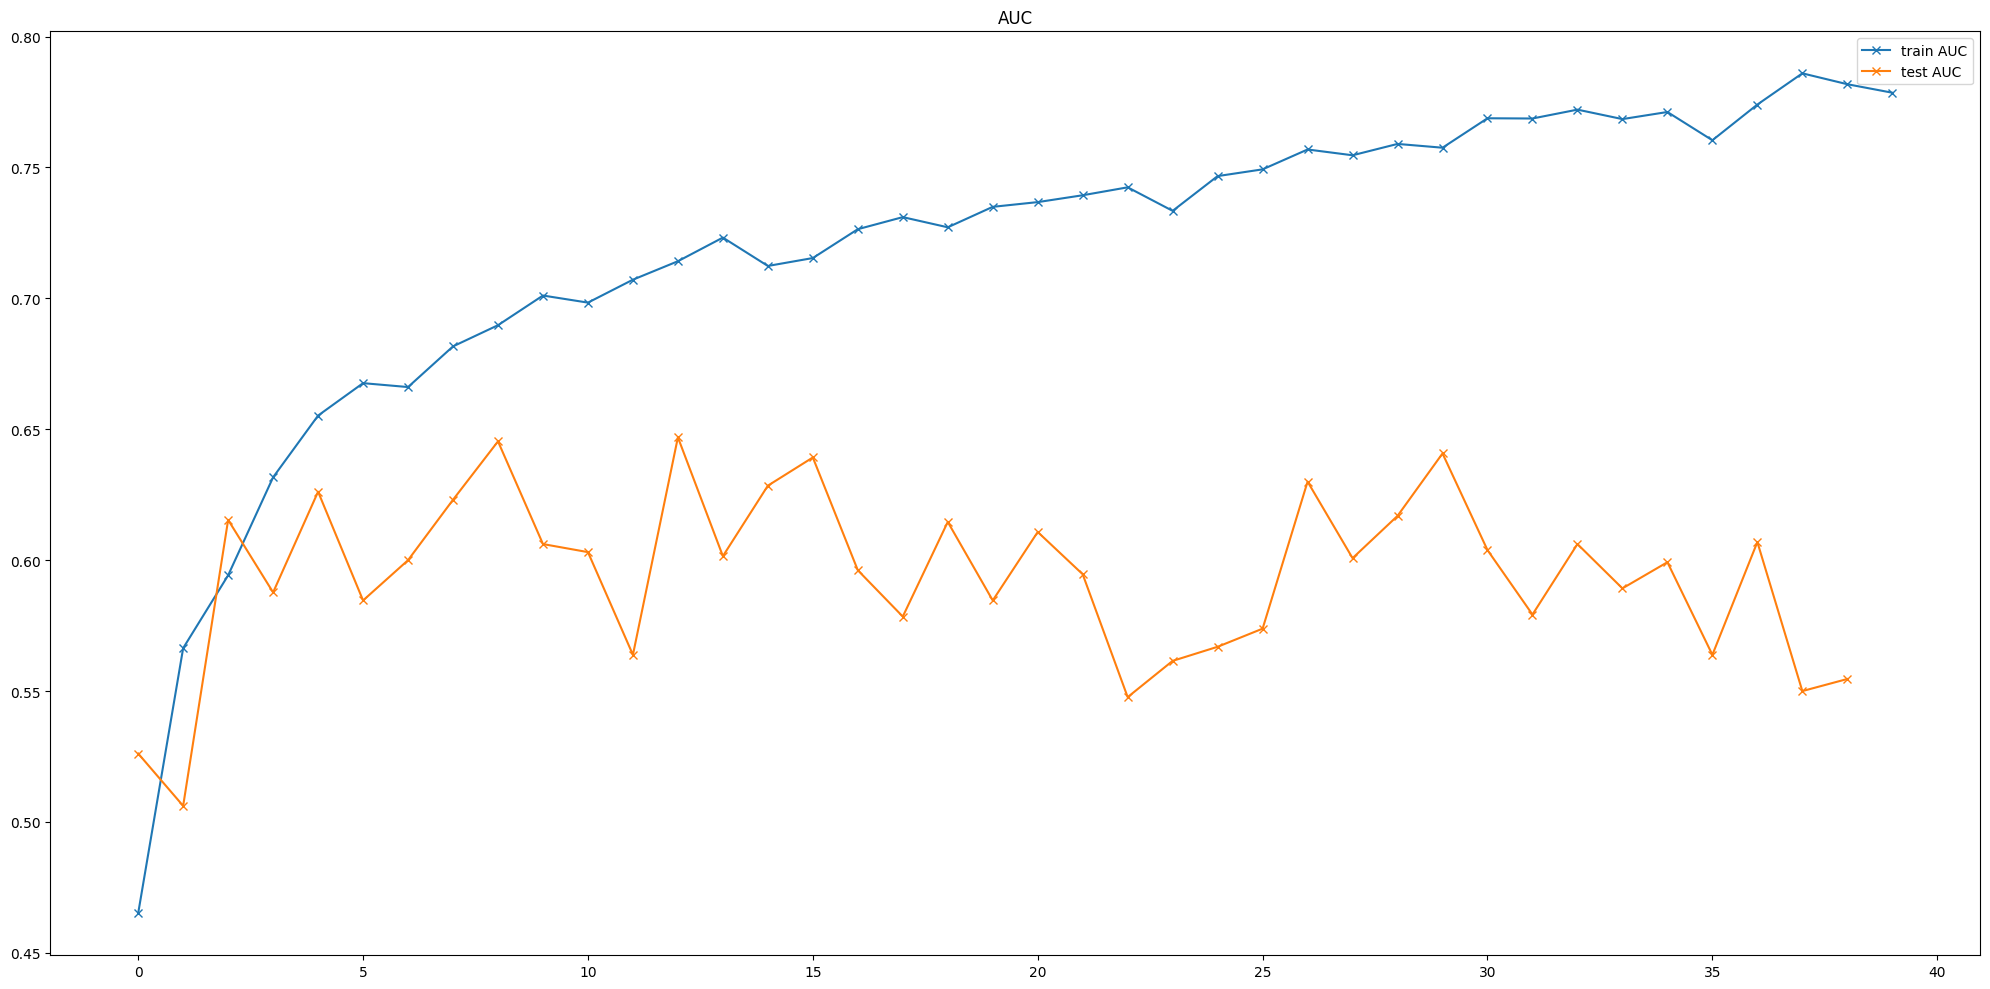

In [18]:
for key, val in aucstats.items():
    t = key.replace(".csv", "").split("-")[0]
    plt.plot(val, label = f"{t} AUC", marker = "x")

plt.title("AUC")
plt.legend()
plt.show()

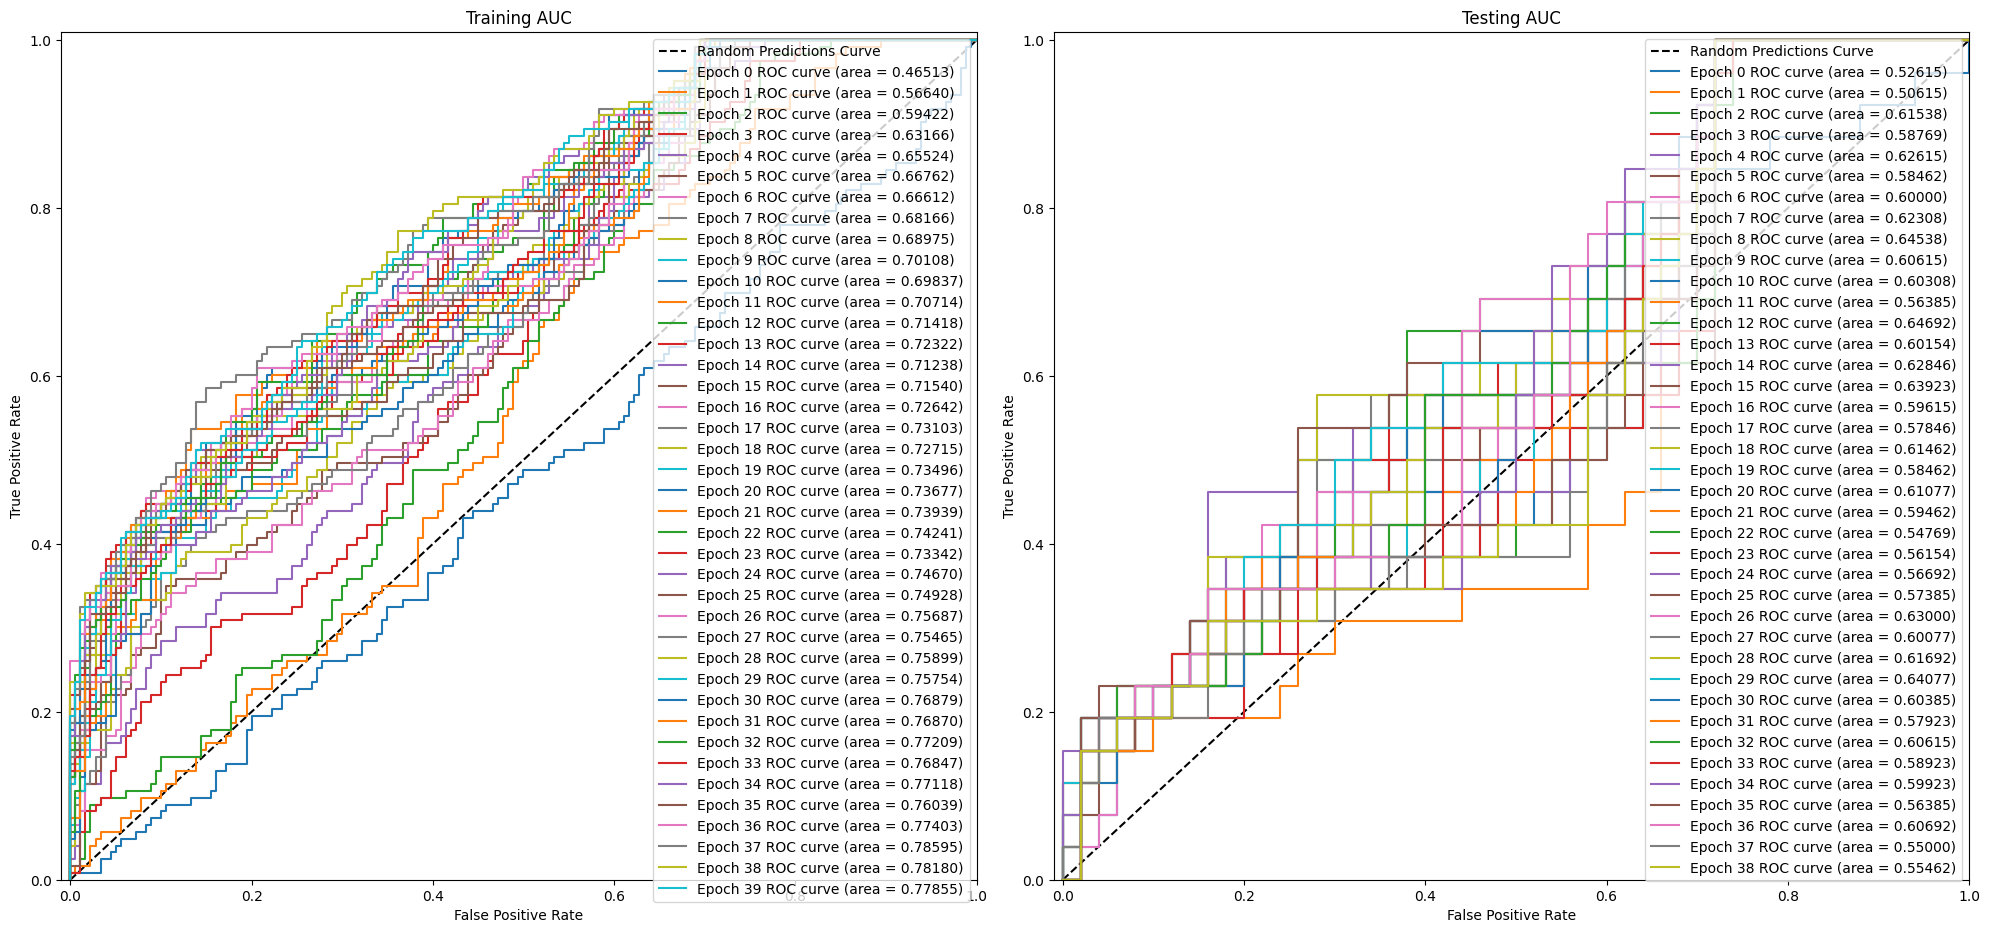

In [19]:
fig, axs = plt.subplots(ncols = 2)

axs[0].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")
axs[1].plot([0, 1], [0, 1], "k--", label = "Random Predictions Curve")

try:
    for epoch in range(maxepochs + 1):
        for key in epochwiseauc.keys():
            fpr, tpr, thresholds = epochwiseauc[key][epoch]
            axs[0 if "train" in key else 1].plot(fpr, tpr, label = f"Epoch {epoch} ROC curve (area = {aucstats[key][epoch]:.5f})")
            axs[0 if "train" in key else 1].set_xlim([-0.01, 1])
            axs[0 if "train" in key else 1].set_ylim([0, 1.01])
            axs[0 if "train" in key else 1].set_xlabel("False Positive Rate")
            axs[0 if "train" in key else 1].set_ylabel("True Positive Rate")
except KeyError:
    pass

axs[0].legend()
axs[1].legend()
axs[0].set_title("Training AUC")
axs[1].set_title("Testing AUC")
plt.show()

In [20]:
import numpy as np
bestepoch = np.argmax(aucstats['test-preds.csv'])
bestepoch

12